<a href="https://colab.research.google.com/github/Fahreiza/Machine_learning_2025/blob/main/JS03_TG2_Fahreiza_Taura_2341720207_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 1


## **Step 1 - Import Library**
Import this following library,

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.metrics import accuracy_score, classification_report

## **Step 2 - Load Data and Group The Data**
Load the data Titanic-Dataset.csv using pandas. Next, we will separate the target variable, namely Survived, and group the data based on numeric and categorical data.

In [84]:
# Load Data
df = pd.read_csv("Titanic-Dataset.csv")

# Pisahkan Survived
y = df["Survived"].astype(int)
X = df.drop(columns=["Survived"])

# Buat list variabel numerik dan kategorikal
# Akan digunakan untuk proses seleksi fitur
# Name tidak akan digunakan karena tidak relevan
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Pclass", "Sex", "Embarked"]

## **Step 3** - Extract The Features
At this stage, we will perform feature extraction based on the data type for each variable. Additionally, we will attempt to use Pipeline from scikit-learn for the feature extraction process. Pipeline is a process model that we can reuse multiple times, making it easier to create models. The feature extraction strategies employed are imputation and scaling. This process can also be done during EDA and preprocessing. Remember, the features in tabular data are actually the columns of the tabular data.

In [85]:
# Ekstaksi Fitur dengan Pipeline

# Data Numerik
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Data Kategorikal
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")) # Added OneHotEncoder
])

### Step 3.1 - Feature Construction
In addition to using existing variables, we can actually create new features in tabular data based on the aggregation or combination of other variables. This step is known as feature construction.

We will create a feature called FamilySize, which is the total family size calculated based on SibSp + Parch + 1. SibSp refers to the number of siblings and spouses. Meanwhile, Parch is data related to the number of parents or children.

In [86]:
# Buat Fitur FamilySize
X["FamilySize"] = X["SibSp"].fillna(0) + X["Parch"].fillna(0) + 1

# Tambahkan FamilySize pada kelompok numerikal
preprocess = ColumnTransformer([
    ("num", num_tf, num_cols + ["FamilySize"]),
    ("cat", cat_tf, cat_cols),
])

## Step 4 - Feature Selection
We will perform a simple feature selection process using the SelectKBest function. This function uses univariate statistics for feature selection. The number of features used corresponds to the specified value of k.

Please refer: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In the context of Titanic data, we will use ANOVA analysis.

In [87]:
from sklearn.feature_selection import f_classif
selector_filter = SelectKBest(score_func=f_classif, k=5)

Next, create the final pipeline for the entire process.

In [88]:
# Seleksi fitur dengan SelectKBest
# Fungsi tersebut akan menggunakan analisis variance
# Baca: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

from sklearn.feature_selection import f_classif
selector_filter = SelectKBest(score_func=f_classif, k=5)

# Buat pipeline final (INGAT INI HANYA PIPELINE, BELUM MEMPROSES DATA)
pipe_filter = Pipeline([
    ("prep", preprocess), # menjalankan pipeline preprocessing
    ("sel", selector_filter), # menjalankan pipeline seleksi fitur
    ("clf", LogisticRegression(max_iter=1000)) # uji dengan model sederhana -> Logistic Regression
])

## **Step 5** - Model Testing
In this step, we will conduct a direct test by training using the Logistic Regression model to determine the results of feature extraction and selection processes on accuracy values.

You will get this following result,

In [89]:
# Lakukan pelatihan dan uji model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipe_filter.fit(X_train, y_train)
pred = pipe_filter.predict(X_test)
print("=== Filter (ANOVA) + LR ===")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

=== Filter (ANOVA) + LR ===
Accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



NB: You may get different result.

Based on this information, we know that the accuracy level obtained is around 0.78 or 78%. The result is quite good but not very effective in determining whether a passenger survived or not. This is closely related to the features used.



So what features are actually being used? We need to conduct an inspection!

Result,

In [90]:
# 1) Nama fitur setelah preprocess
feat_names = pipe_filter.named_steps["prep"].get_feature_names_out()
print("Nama fitur:", feat_names)
print("\n")

# 2) Mask & skor fitur terpilih (SelectKBest)
sel = pipe_filter.named_steps["sel"]
mask = sel.get_support()
selected_names = feat_names[mask]
selected_scores = sel.scores_[mask]
top = sorted(zip(selected_names, selected_scores), key=lambda t: t[1], reverse=True)[:10]
print("Top fitur:", top)

Nama fitur: ['num__Age' 'num__SibSp' 'num__Parch' 'num__Fare' 'num__FamilySize'
 'cat__Pclass_1' 'cat__Pclass_2' 'cat__Pclass_3' 'cat__Sex_female'
 'cat__Sex_male' 'cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S']


Top fitur: [('cat__Sex_female', np.float64(306.5932488951883)), ('cat__Sex_male', np.float64(306.59324889518797)), ('cat__Pclass_3', np.float64(80.33862734392042)), ('cat__Pclass_1', np.float64(73.99727564291717)), ('num__Fare', np.float64(58.31490728198491))]


We can determine that the 78% accuracy was obtained from features.

result,

In [91]:
feat_names = pipe_filter.named_steps["prep"].get_feature_names_out()
print("Nama fitur:", feat_names, "\n")

sel = pipe_filter.named_steps["sel"]
mask = sel.get_support()
selected_names = feat_names[mask]
selected_scores = sel.scores_[mask]

top = sorted(zip(selected_names, selected_scores), key=lambda t: t[1], reverse=True)[:10]
print("Top fitur:", top)

Nama fitur: ['num__Age' 'num__SibSp' 'num__Parch' 'num__Fare' 'num__FamilySize'
 'cat__Pclass_1' 'cat__Pclass_2' 'cat__Pclass_3' 'cat__Sex_female'
 'cat__Sex_male' 'cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S'] 

Top fitur: [('cat__Sex_female', np.float64(306.5932488951883)), ('cat__Sex_male', np.float64(306.59324889518797)), ('cat__Pclass_3', np.float64(80.33862734392042)), ('cat__Pclass_1', np.float64(73.99727564291717)), ('num__Fare', np.float64(58.31490728198491))]


# Lab 2

**Intro**

In this practicum, we will perform feature extraction using the TF-IDF method with very simple data. The sample text documents consist of only a few sentences. These documents are collected into a corpus. Subsequently, each document within the corpus will undergo feature extraction.



Step 0 - Prepare The Corpus Data

In [92]:
corpus = [
    'the house had a tiny little mouse',
    'the cat saw the mouse',
    'the mouse ran away from the house',
    'the cat finally ate the mouse',
    'the end of the mouse story'
]

## **Step 1** - Construct TF-IDF Model

You will obtain the vector representation of each word in the document.

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisiasi obyek TFidfVectorizer
vect = TfidfVectorizer(stop_words='english')

# Pembobotan TF-IDF
resp = vect.fit_transform(corpus)

# Cetak hasil
print(resp)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 18 stored elements and shape (5, 12)>
  Coords	Values
  (0, 5)	0.47557510189256375
  (0, 11)	0.5894630806320427
  (0, 6)	0.5894630806320427
  (0, 7)	0.2808823162882302
  (1, 7)	0.3477147117091919
  (1, 2)	0.5887321837696324
  (1, 9)	0.7297183669435993
  (2, 5)	0.47557510189256375
  (2, 7)	0.2808823162882302
  (2, 8)	0.5894630806320427
  (2, 1)	0.5894630806320427
  (3, 7)	0.2808823162882302
  (3, 2)	0.47557510189256375
  (3, 4)	0.5894630806320427
  (3, 0)	0.5894630806320427
  (4, 7)	0.3193023297639811
  (4, 3)	0.6700917930430479
  (4, 10)	0.6700917930430479


The results show that,

Input:

(row, column) -> The row index represents the document in the corpus, while the column represents the index of the word within the features.

Input:

Values -> weights of the vectorization process in TF-IDF

## **Step 2** - Check The Words Used as Features

you will get,

In [94]:
print(vect.get_feature_names_out())

['ate' 'away' 'cat' 'end' 'finally' 'house' 'little' 'mouse' 'ran' 'saw'
 'story' 'tiny']


# Lab 3

Pada pratikum ini, kita akan mencoba untuk mengekstraksi fitur dari sebuah citra. Proses yang akan kita lakukan hanya proses sederhana. Pembahasan lengkap terkait dengan pra pengolahan data dan ekstraksi fitur pada data citra akan dibahas pada perkuliahan pengolahan citra digital.

Data yang akan kita gunakan adalah citra berikut.

## Step 0 - Instal Required Library
In this lab, we will use the pillow library. Install pillow first if it is not yet installed on your device.

Run this following command on the notebook

In [95]:
!pip install Pillow

## Step 1 - Load The Image

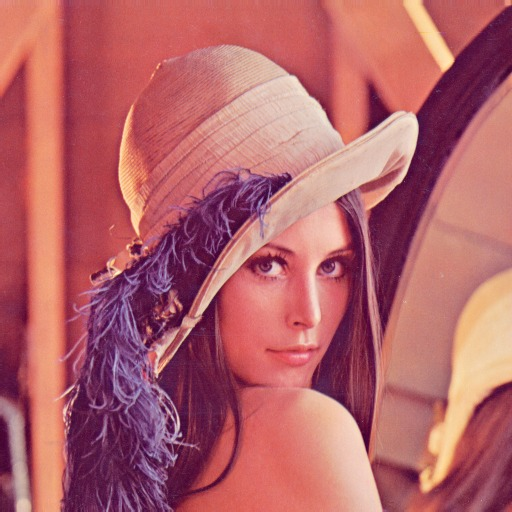

In [96]:
from PIL import Image

img = Image.open('/content/lenna.jpg')
img.show() # tampilkan gambar
display(img) # metode alternatif tampilkan gambar

## Step 2 - Ekstrak Fitur

You will receive histogram values in the form of an array,

In [97]:
# Ekstrak setiap channel red, green, blue
r, g, b = img.split()

# Cek panjang ukuran channel red
print(len(r.histogram()))

# Cetak fitur histogram pada channel red
print(r.histogram())

256
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 3, 6, 9, 8, 14, 14, 20, 36, 36, 44, 85, 113, 135, 167, 188, 215, 282, 333, 380, 433, 491, 609, 694, 772, 816, 979, 1013, 1105, 1208, 1346, 1389, 1446, 1533, 1606, 1647, 1686, 1657, 1625, 1624, 1584, 1598, 1483, 1543, 1434, 1255, 1249, 1172, 1083, 977, 953, 903, 887, 789, 813, 715, 661, 683, 651, 611, 610, 595, 600, 582, 593, 558, 486, 563, 606, 586, 600, 593, 590, 629, 617, 604, 608, 627, 691, 685, 680, 657, 677, 727, 710, 760, 734, 690, 735, 744, 728, 780, 770, 801, 798, 809, 872, 777, 850, 876, 880, 908, 856, 868, 930, 947, 904, 953, 983, 1005, 1114, 1191, 1202, 1303, 1362, 1466, 1606, 1852, 1810, 1847, 1801, 1758, 1724, 1545, 1501, 1500, 1443, 1421, 1511, 1503, 1631, 1674, 1697, 1823, 1774, 1797, 1966, 1840, 1946, 1872, 1946, 1950, 2024, 2168, 2316, 2486, 2800, 2882, 3118, 3342, 3346, 3347, 3263, 3168, 2970

# Lab Assignment - Wisconsin Breast Cancer Dataset Analysis

**Assignment Description:**

In this practical assignment, we will use the "Wisconsin Breast Cancer" dataset (`wbc.csv`) to diagnose the types of cancer (Malignant (M) and Benign (B)). Our task is to perform the following steps:

1.  Separate usable variables from unusable variables.
2.  Encode the "diagnosis" column.
3.  Standardize all columns with numeric values.
4.  Perform feature selection using SelectKBest.
5.  Perform the testing process using the Logistic Regression model.
6.  Utilize a model pipeline for a streamlined workflow.
7.  Identify and report the best features used for prediction.

## Step 1: Load the Dataset

Load the "wbc.csv" file into a pandas DataFrame and display the first few rows to inspect the data.

In [116]:
import pandas as pd

df = pd.read_csv('/content/wbc.csv')
display(df.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Step 2: Separate Features and Target

Separate the features (all columns except 'diagnosis' and 'id', and 'Unnamed: 32') from the target variable ('diagnosis').

In [117]:
X = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32'])
y = df['diagnosis']
display(X.head())
display(y.head())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,diagnosis
0,M
1,M
2,M
3,M
4,M


## Step 3: Encode the Target Variable

Encode the categorical 'diagnosis' column into numerical values (0 and 1).

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
display(y[:5])

array([1, 1, 1, 1, 1])

## Step 4: Standardize Numeric Features

Standardize all numeric columns in the feature set (`X`) using `StandardScaler`.

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
display(X_scaled[:5])

array([[ 1.09706398e+00, -2.07333501e+00,  1.26993369e+00,
         9.84374905e-01,  1.56846633e+00,  3.28351467e+00,
         2.65287398e+00,  2.53247522e+00,  2.21751501e+00,
         2.25574689e+00,  2.48973393e+00, -5.65265059e-01,
         2.83303087e+00,  2.48757756e+00, -2.14001647e-01,
         1.31686157e+00,  7.24026158e-01,  6.60819941e-01,
         1.14875667e+00,  9.07083081e-01,  1.88668963e+00,
        -1.35929347e+00,  2.30360062e+00,  2.00123749e+00,
         1.30768627e+00,  2.61666502e+00,  2.10952635e+00,
         2.29607613e+00,  2.75062224e+00,  1.93701461e+00],
       [ 1.82982061e+00, -3.53632408e-01,  1.68595471e+00,
         1.90870825e+00, -8.26962447e-01, -4.87071673e-01,
        -2.38458552e-02,  5.48144156e-01,  1.39236330e-03,
        -8.68652457e-01,  4.99254601e-01, -8.76243603e-01,
         2.63326966e-01,  7.42401948e-01, -6.05350847e-01,
        -6.92926270e-01, -4.40780058e-01,  2.60162067e-01,
        -8.05450380e-01, -9.94437403e-02,  1.80592744e+

## Step 5: Build a Pipeline with Feature Selection and Model

Create a pipeline that includes `StandardScaler`, `SelectKBest` for feature selection (using `f_classif` and selecting the top 10 features), and a `LogisticRegression` model.

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', LogisticRegression(max_iter=1000))
])

## Step 6: Split Data into Training and Testing Sets

Split the standardized feature data (`X_scaled`) and the encoded target variable (`y`) into training and testing sets.

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Step 7: Train and Evaluate the Model

Train the pipeline on the training data and evaluate its performance on the testing data using accuracy and a classification report.

In [122]:
from sklearn.metrics import accuracy_score, classification_report

model_pipeline.fit(X_train, y_train)
predictions = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## Step 8: Identify the Best Features

Identify the best features that were selected by the `SelectKBest` step within the pipeline.

In [123]:
selector = model_pipeline.named_steps['selector']
mask = selector.get_support()
original_feature_names = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32']).columns
selected_features = original_feature_names[mask]
print("Best features selected by SelectKBest:")
print(selected_features)

Best features selected by SelectKBest:
Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')


## Summary of Findings

Based on the analysis:

*   The dataset was loaded, and irrelevant columns ('id', 'Unnamed: 32') were removed.
*   The target variable 'diagnosis' was encoded.
*   Numeric features were standardized.
*   `SelectKBest` identified the top 10 features.
*   A pipeline with standardization, feature selection, and Logistic Regression was built and evaluated.
*   The model achieved an accuracy of approximately 95.61% on the test set.
*   The best features for predicting breast cancer diagnosis in this model are: `radius_mean`, `perimeter_mean`, `area_mean`, `concavity_mean`, `concave points_mean`, `radius_worst`, `perimeter_worst`, `area_worst`, `concavity_worst`, and `concave points_worst`.